In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

In [2]:
file_path = os.path.join('data', 'NYCTaxiFares.csv')
df = pd.read_csv(file_path)

In [20]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [21]:
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

In [22]:
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")

In [23]:
categorical_columns = ['Hour', 'AMorPM', 'Weekday']
continious_columns = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
y_column = ['fare_amount']

In [24]:
# Convert our three categorical columns to category dtypes.
for category in categorical_columns:
    df[category] = df[category].astype('category')

In [25]:
hour = df['Hour'].cat.codes.values
am_pm = df['AMorPM'].cat.codes.values
week_day = df['Weekday'].cat.codes.values

categories = np.stack([hour, am_pm, week_day], 1)

In [26]:
# Convert categorical variables to a tensor
categories = torch.tensor(categories, dtype=torch.int64) 

In [27]:
# Convert continuous variables to a tensor
continiouses = np.stack([df[columns].values for columns in continious_columns], 1)
continiouses = torch.tensor(continiouses, dtype=torch.float)

In [28]:
# Convert labels to a tensor
y = torch.tensor(df[y_column].values, dtype=torch.float).reshape(-1,1)

In [29]:
# This will set embedding sizes for Hours, AMvsPM and Weekdays
categories_sizes = [len(df[column].cat.categories) for column in categorical_columns]
embedding_sizes = [(size, min(50, (size+1)//2)) for size in categories_sizes]

In [30]:
class TabularModel(nn.Module):

    def __init__(self, embedding_sizes, continious_no, out_size, layers, probability=0.5):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(size_of_category, size_of_embed) for size_of_category,size_of_embed in embedding_sizes])
        self.embedding_drop = nn.Dropout(probability)
        self.continious_normalization = nn.BatchNorm1d(continious_no)
        
        layer_list = []
        embedding_no = sum((size_of_embed for size_of_category,size_of_embed in embedding_sizes))
        input_no = embedding_no + continious_no
        
        for layer_width in layers:
            layer_list.append(nn.Linear(input_no,layer_width)) 
            layer_list.append(nn.ReLU(inplace=True))
            layer_list.append(nn.BatchNorm1d(layer_width))
            layer_list.append(nn.Dropout(probability))
            input_no = layer_width
        layer_list.append(nn.Linear(layers[-1],out_size))
            
        self.layers = nn.Sequential(*layer_list)
    
    def forward(self, x_categorical, x_continious):
        embeddings_list = []
        for i,e in enumerate(self.embeddings):
            embeddings_list.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings_list, 1)
        x = self.embedding_drop(x)
        
        x_continious = self.continious_normalization(x_continious)
        x = torch.cat([x, x_continious], 1)
        x = self.layers(x)
        return x

In [31]:
torch.manual_seed(33)
model = TabularModel(embedding_sizes, continiouses.shape[1], 1, [200,100], probability=0.4)

In [32]:
criterion = nn.MSELoss()  # we'll convert this to RMSE later
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [33]:
batch_size = 1000 #the amount of samples is len(df)=120,000 but just for the sake of running faster here I used this
test_size = int(batch_size * .2)

categories_train = categories[:batch_size-test_size]
categories_test = categories[batch_size-test_size:batch_size]
continiouses_train = continiouses[:batch_size-test_size]
continiouses_test = continiouses[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [34]:
#train the model
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_prediction = model(categories_train, continiouses_train)
    loss = torch.sqrt(criterion(y_prediction, y_train)) # RMSE
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 12.24625492
epoch:  26  loss: 10.67411137
epoch:  51  loss: 9.78016281
epoch:  76  loss: 9.18004036
epoch: 101  loss: 8.65494728
epoch: 126  loss: 7.97454071
epoch: 151  loss: 7.02165031
epoch: 176  loss: 5.86341429
epoch: 201  loss: 4.61483669
epoch: 226  loss: 3.50409222
epoch: 251  loss: 3.10732770
epoch: 276  loss: 3.07376719
epoch: 300  loss: 2.78747272

Duration: 2 seconds


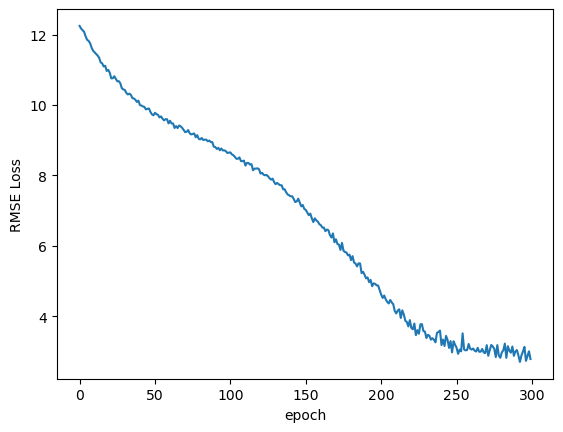

In [35]:
#plot the loss function
with torch.no_grad():
    plt.plot(range(epochs), losses)
    plt.ylabel('RMSE Loss')
    plt.xlabel('epoch');

In [36]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_validation = model(categories_test, continiouses_test)
    loss = torch.sqrt(criterion(y_validation, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 3.72431517
